## Install modules, import

In [1]:
# %%capture
# !pip install optuna pycaret rdkit

In [2]:
# Print versions used in the Notebook
# Python
import sys
print('Python: {}'.format(sys.version))
# numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# # optuna
# import optuna
# print('optuna: {}'.format(optuna.__version__))
# pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# # pickle
# import pickle
# print('pickle: {}'.format(pickle.format_version))
# pycaret
import pycaret
print('pycaret: {}'.format(pycaret.__version__))
# rdkit
import rdkit
print('rdkit: {}'.format(rdkit.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))

Python: 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:29:51) [MSC v.1929 64 bit (AMD64)]
numpy: 1.22.4
pandas: 1.5.3
pycaret: 3.0.4
rdkit: 2023.03.2
sklearn: 1.2.2


In [3]:
from pycaret.classification import *
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

In [4]:
# Set a random seed for reproducibility
random_seed = 1234
np.random.seed(random_seed)

# Display complete pandas DataFrames
pd.options.display.max_rows = None
pd.options.display.max_columns = None

## Define model quality metrics

In [5]:
from sklearn.metrics import *
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 14})

In [6]:
# Dictionary with metrics and labels
metrics_d = {'Accuracy': 'accuracy',
             'AUC': 'roc_auc',
             'Recall': 'recall',
             'Prec.': 'precision',
             'F1': make_scorer(f1_score),
             'Kappa': make_scorer(cohen_kappa_score),
             'MCC': make_scorer(matthews_corrcoef),
             'AUPRC': 'average_precision'}

## Set Fingerprint generator

In [7]:
fp_size = 1024
fp_radius = 3

In [8]:
# Create RDKit fingerprint generator object
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=fp_radius, fpSize=fp_size)

# Cruzain

## Enzyme code

In [10]:
# Enzyme code
enz = 'cruz'

In [11]:
# Import dataset
df = pd.read_csv(f'{enz}_final.csv', sep=";")

## Train models using PyCaret

In [12]:
# Create dataset with Morgan FPs and binary target

X = df["standard_SMILES"].apply(lambda smi: mfpgen.GetFingerprintAsNumPy(Chem.MolFromSmiles(smi)))
X = np.vstack(X)  # convert to 2D array of shape n_samples, fpSize
y = df["Active"].copy()

df_morgan = pd.DataFrame(X, columns=[str(i) for i in range(fp_size)])
df_morgan["Active"] = y

In [13]:
print("Actives:", df_morgan["Active"].sum())
print("Inactives:", len(df_morgan["Active"]) - df_morgan["Active"].sum())

Actives: 343
Inactives: 514


In [14]:
# help(setup)

In this version of pycaret (3.0.4), the following are default parameters and don't need to be set:
preprocess=False, low_variance_threshold=None, remove_multicollinearity=False, data_split_stratify=True, fold_strategy='stratifiedkfold',

Non-default:
train_size=0.8, fold=5, session_id=1234, verbose=False

In [15]:
clf = setup(data=df_morgan, train_size=0.8,
            numeric_features=list(df_morgan.columns[:-1]),
            fold=5, session_id=1234, verbose=False)

In [16]:
# Average precision score is AUPRC
# https://sinyi-chou.github.io/python-sklearn-precision-recall/
# from sklearn.metrics import average_precision_score

add_metric('auprc', 'AUPRC', average_precision_score, target='pred_proba')

Name                                                             AUPRC
Display Name                                                     AUPRC
Score Function       <function average_precision_score at 0x0000017...
Scorer               make_scorer(average_precision_score, needs_pro...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: auprc, dtype: object

In [17]:
compare_models(sort='MCC', errors="raise")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC,TT (Sec)
et,Extra Trees Classifier,0.8467,0.8994,0.7556,0.8479,0.7977,0.6750,0.6793,0.8674,1.2880
rf,Random Forest Classifier,0.8321,0.9033,0.7335,0.8343,0.7775,0.6437,0.6502,0.8841,0.9920
gbc,Gradient Boosting Classifier,0.8292,0.8951,0.7078,0.8430,0.7681,0.6345,0.6419,0.8790,1.3340
lr,Logistic Regression,0.8263,0.9050,0.7590,0.7981,0.7767,0.6348,0.6368,0.8821,2.1500
lightgbm,Light Gradient Boosting Machine,0.8248,0.8985,0.7407,0.8099,0.7715,0.6301,0.6340,0.8734,1.2060
knn,K Neighbors Classifier,0.8146,0.8930,0.7296,0.7960,0.7575,0.6082,0.6134,0.8330,0.5480
dt,Decision Tree Classifier,0.8015,0.7974,0.7774,0.7419,0.7586,0.5903,0.5914,0.6667,0.6020
svm,SVM - Linear Kernel,0.7898,0.0000,0.7227,0.7460,0.7291,0.5583,0.5634,0.0000,0.2620
ada,Ada Boost Classifier,0.7796,0.8443,0.7081,0.7339,0.7196,0.5383,0.5397,0.8023,0.9040
ridge,Ridge Classifier,0.7723,0.0000,0.7699,0.6968,0.7298,0.5341,0.5383,0.0000,0.3120


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=1234, verbose=0, warm_start=False)

## Validation

In [18]:
# Create model = 10-fold cv (internal validation)
best = create_model('et', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
Fold,,,,,,,,
0,0.8696,0.9312,0.7778,0.8750,0.8235,0.7206,0.7238,0.8717
1,0.8696,0.9429,0.7857,0.8800,0.8302,0.7249,0.7279,0.9172
2,0.8406,0.8275,0.7857,0.8148,0.8000,0.6675,0.6678,0.8347
3,0.8696,0.9103,0.7500,0.9130,0.8235,0.7216,0.7304,0.8825
4,0.8116,0.8580,0.6786,0.8261,0.7451,0.5979,0.6052,0.8039
5,0.8676,0.9422,0.7778,0.8750,0.8235,0.7182,0.7214,0.9364
6,0.7794,0.8799,0.7037,0.7308,0.7170,0.5364,0.5366,0.8645
7,0.8824,0.9196,0.7778,0.9130,0.8400,0.7479,0.7539,0.9164
8,0.8235,0.9210,0.7407,0.8000,0.7692,0.6267,0.6279,0.8506


In [19]:
best_df = pull()
best_df.loc['95_CI', :] = 1.96*best_df.loc['Std', :]

In [20]:
for val, name in enumerate(metrics_d.keys()):
    print(f"{name:{12}} = {best_df.iloc[10, val]:.3f} ± {best_df.iloc[12, val]:.3f}")

Accuracy     = 0.848 ± 0.062
AUC          = 0.905 ± 0.071
Recall       = 0.763 ± 0.090
Prec.        = 0.845 ± 0.106
F1           = 0.801 ± 0.079
Kappa        = 0.679 ± 0.130
MCC          = 0.682 ± 0.132
AUPRC        = 0.871 ± 0.079


In [21]:
# Prediction on test set (external validation)
pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
0,Extra Trees Classifier,0.8372,0.8949,0.7101,0.8596,0.7778,0.6512,0.6586,0.8329


In [22]:
pred_df = pull()

## Plots

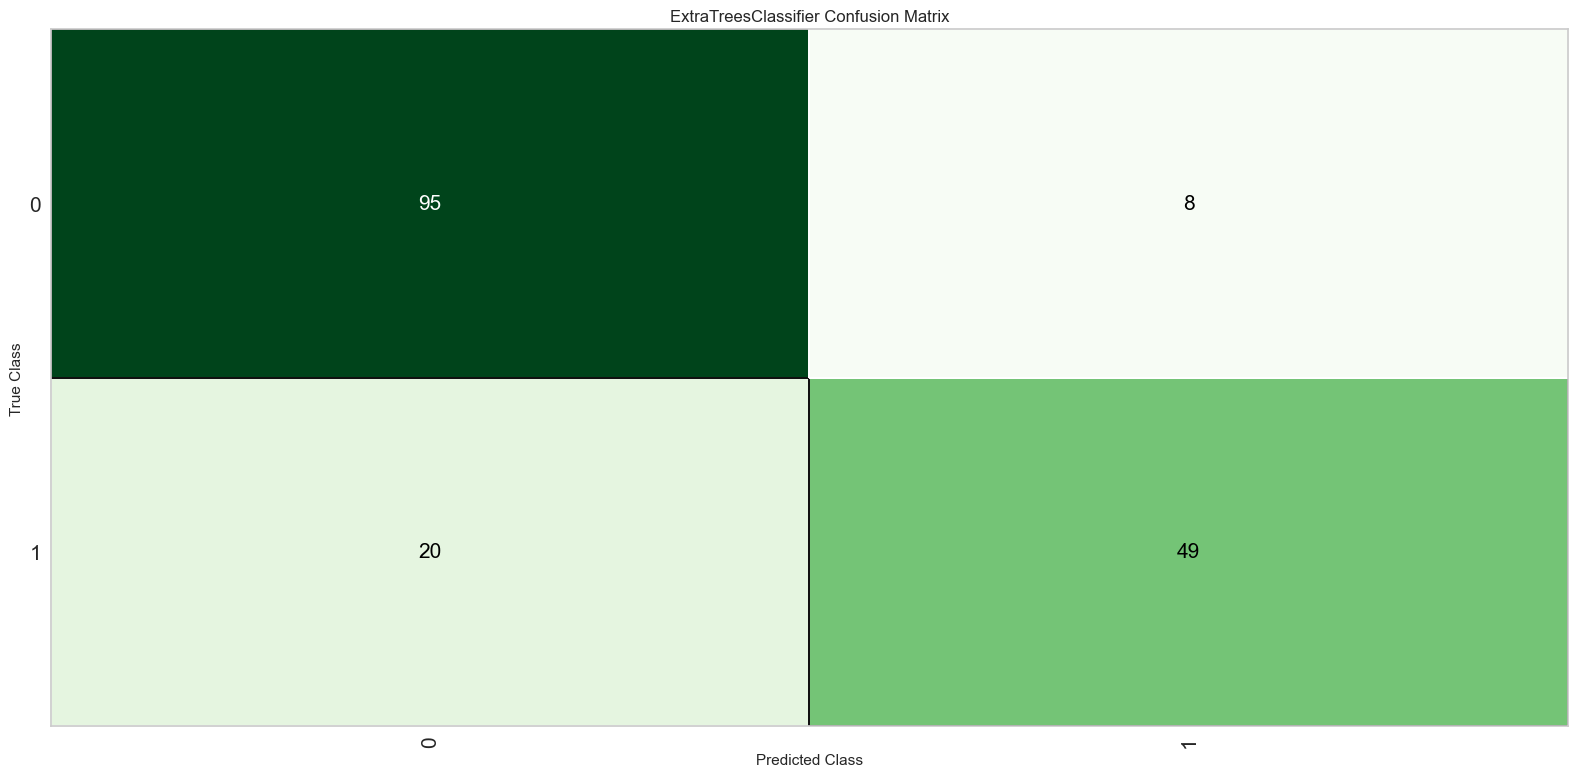

In [23]:
# Confusion matrix
plot_model(best, plot='confusion_matrix')

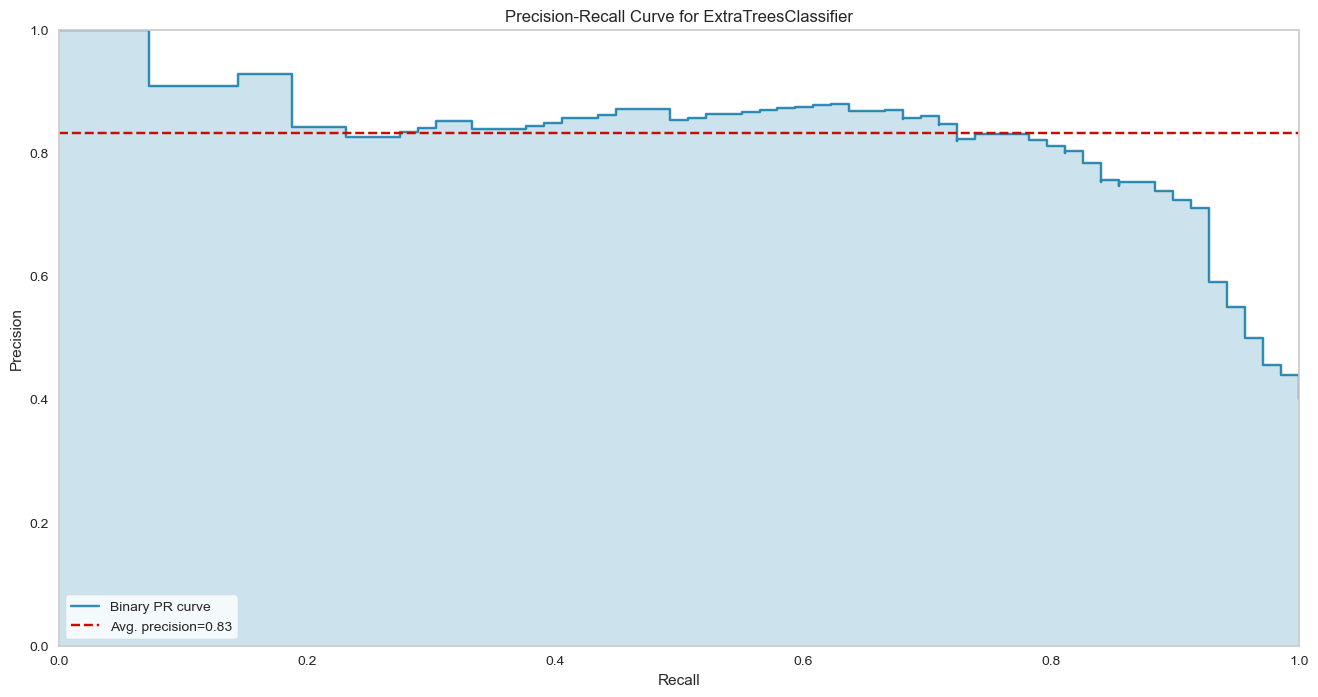

In [24]:
# Precision-Recall curve
plot_model(best, plot='pr')

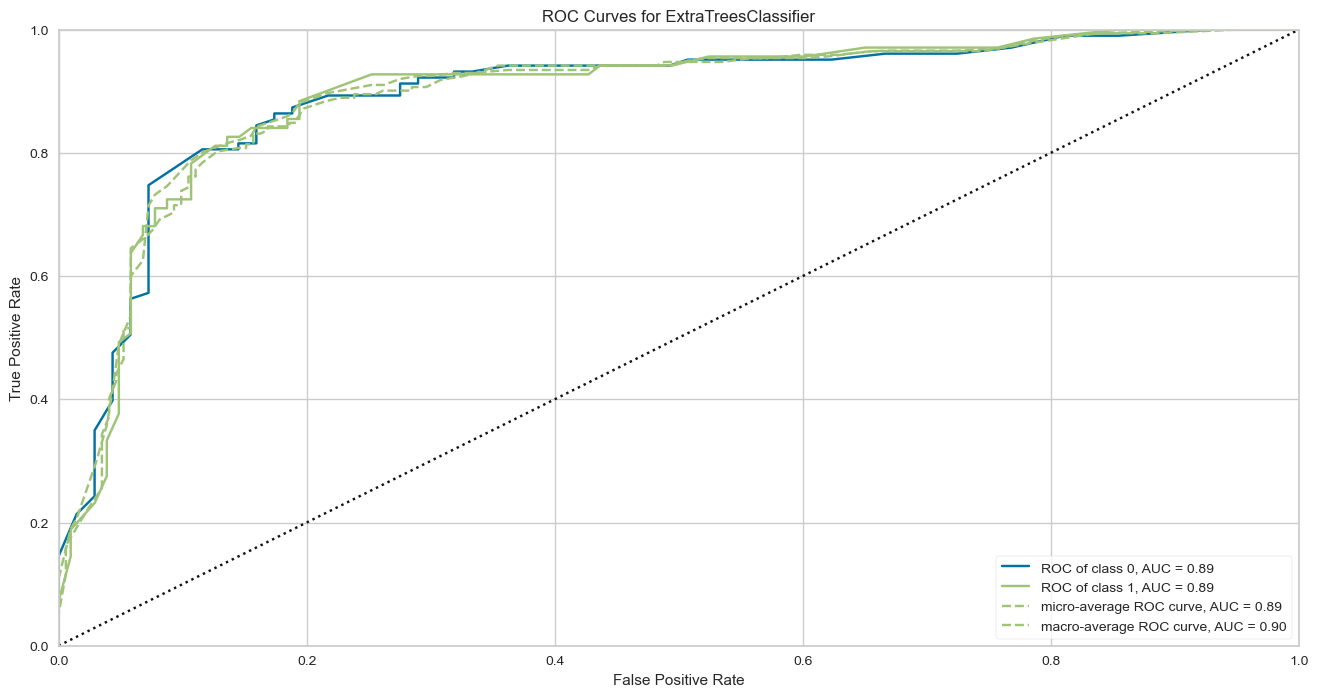

In [25]:
# ROC-AUC
plot_model(best, plot='auc')

## Define model

In [26]:
print(best)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=1234, verbose=0, warm_start=False)


In [27]:
from sklearn.ensemble import ExtraTreesClassifier

In [28]:
model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=1234, verbose=0, warm_start=False)


## y-randomization

In [29]:
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.utils import shuffle

yrand_scores = pd.DataFrame()

for i in range(10):
    y_rand = shuffle(y, random_state=i)
    cv1 = StratifiedShuffleSplit(n_splits=1, random_state=1234, test_size=0.2)
    yrand_score = cross_validate(model, X, y_rand, cv=cv1, scoring=metrics_d)
    yrand_scores = yrand_scores.append(yrand_score, ignore_index=True)

yrand_scores = yrand_scores.iloc[:, 2:]
yrand_scores.columns = list(metrics_d.keys())
yrand_scores.loc['Average'] = yrand_scores.mean()
yrand_scores.loc['95_CI'] = 1.96*yrand_scores.std()
yrand_scores

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
0,[0.5465116279069767],[0.49521598424088925],[0.30434782608695654],[0.4117647058823529],[0.35],[0.013674459638288394],[0.0140430686083025],[0.4193063348696344]
1,[0.5813953488372093],[0.45792880258899676],[0.3188405797101449],[0.46808510638297873],[0.3793103448275862],[0.08035051240160407],[0.08372403911283878],[0.41457852918187144]
2,[0.5406976744186046],[0.5353172928099057],[0.37681159420289856],[0.41935483870967744],[0.39694656488549623],[0.027761877504293042],[0.027865470788495526],[0.41483421466827597]
3,[0.5523255813953488],[0.4907133811734909],[0.2898550724637681],[0.4166666666666667],[0.3418803418803419],[0.01896296296296296],[0.01968046478032848],[0.40540379312029484]
4,[0.4941860465116279],[0.4704516673701984],[0.2608695652173913],[0.3333333333333333],[0.2926829268292683],[-0.09194395796847621],[-0.09361803218139882],[0.43092076864951584]
5,[0.48255813953488375],[0.44231039819895873],[0.21739130434782608],[0.3],[0.25210084033613445],[-0.12824292452830188],[-0.13213296406728323],[0.3579671203104438]
6,[0.563953488372093],[0.5246939636977627],[0.36231884057971014],[0.44642857142857145],[0.4],[0.06331687481847226],[0.06416826892431013],[0.44925461928513777]
7,[0.5697674418604651],[0.5252567890811876],[0.34782608695652173],[0.4528301886792453],[0.39344262295081966],[0.06891002194586693],[0.07035036157832356],[0.40775156575305116]
8,[0.5697674418604651],[0.5187842971718024],[0.3188405797101449],[0.4489795918367347],[0.3728813559322034],[0.05955371656568642],[0.061575974356177315],[0.4258386500520557]
9,[0.563953488372093],[0.5519206416209371],[0.37681159420289856],[0.4482758620689655],[0.4094488188976378],[0.06791907514450857],[0.06856275777950181],[0.4618022312353487]


In [30]:
for val, name in enumerate(metrics_d.keys()):
    print(f"{name:{12}} = {yrand_scores.iloc[10, val]:.3f} ± {yrand_scores.iloc[11, val]:.3f}")

Accuracy     = 0.547 ± 0.061
AUC          = 0.501 ± 0.067
Recall       = 0.317 ± 0.096
Prec.        = 0.415 ± 0.103
F1           = 0.359 ± 0.095
Kappa        = 0.018 ± 0.133
MCC          = 0.018 ± 0.137
AUPRC        = 0.419 ± 0.052


In [31]:
# Final validation df
valid_df = pd.DataFrame()
valid_df = valid_df.append(best_df.loc['Mean', :])
valid_df = valid_df.append(best_df.loc['95_CI', :])
valid_df = valid_df.append(pred_df.iloc[0,:][1:])
valid_df = valid_df.append(yrand_scores.loc['Average', :])
valid_df = valid_df.append(yrand_scores.loc['95_CI', :])
valid_df.index = ['10-fold CV Mean', '10-fold CV 95_CI', 'pred', 'y-rand Mean', 'y-rand 95_CI']

valid_df

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
10-fold CV Mean,0.848100,0.905300,0.763000,0.844900,0.800800,0.678700,0.682100,0.871200
10-fold CV 95_CI,0.062132,0.070952,0.089572,0.105840,0.079184,0.129752,0.131516,0.078988
pred,0.837200,0.894900,0.710100,0.859600,0.777800,0.651200,0.658600,0.832900
y-rand Mean,0.546512,0.501259,0.317391,0.414572,0.358869,0.018026,0.018422,0.418766
y-rand 95_CI,0.061366,0.066778,0.096287,0.102640,0.095331,0.133426,0.136863,0.051890


## Fit final model on entire dataset and export

In [32]:
# Fit final model on entire dataset
model.fit(X, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=1234, verbose=0, warm_start=False)

In [34]:
import pickle

In [35]:
# Output pickle object containing model
pkl_obj = model

with open(f"cruz_new_model.pkl", 'ab+') as file:
    pickle.dump(pkl_obj, file)